/Users/frhyme/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
"""
- 우리는 좀전까지 Frozen world를 대상으로 강화학습을 수행했습니다. 그리고 Q(quality) table을 만들어서, 매 스텝이 reward에 얼마나 기여하는지를 측정했죠. 
- 이것이 가능했던 것은, action_space는 4이고, observation_space는 16(4 by 4)이기 때문입니다. 큐테이블이 16 by 4면 되니까요. 
- 하지만, 바둑, 아니 오목의 예를 들어봅시다. action_space와 obser_space가 너무 많아집니다.
    - 간단하게, 바둑판을 4*4로 두고, math.factorial(16)*2로만 계산해도, 41845579776000의 값이 나옵니다. 표현되는 observation_space가 너무 많다는 생각이 듭니다. 
- 실제로 강화학습을 적용해야 하는 경우는 아주 많은 관찰 가지수와, 액션 스페이스로 구성되는데, 이를 큐테이블로 적용할 수는 없어요. 
- 그래요. 좋습니다. 그럼 이제 어떻게 해야 하는지 알려주시죠? 
- a....Approximation!!. 
- 예측합시다 하하하핫

"""
print("dd")

In [220]:
import gym
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt

def one_hot(x):
    return np.identity(16)[x:x+1]

env = gym.make('FrozenLake-v0')
"""
- obervation(현재 상황)을 입력받아서, 적절한 action을 내뱉는 네트워크를 구성합니다. 
- 사실, 이건 히든 레이어가 없는 네트워크라서 그냥 linear regression이라고 해도 상관없긴 합니다. 

- 그래요. 다 알겠는데 뭐가 X ,Y 인가요? 
X: observation 
Y: action 별 Quality 
"""
input_size = env.observation_space.n
output_size = env.action_space.n

learning_rate, decay_rate, num_episodes= 0.1, 0.99, 30000

X = tf.placeholder(shape=[1, input_size], dtype=tf.float32)
# X는 개별 상황, 즉 여기서는 16가지. 
W = tf.Variable(tf.random_uniform([input_size, output_size], 0, 0.01))

Qpred = tf.matmul(X, W) # 우리가 예측하는, Q 
Y = tf.placeholder(shape=[1, output_size], dtype=tf.float32)
# Y는 개별 상황(X)에서 취할 수 있는 action의 quality를 예측 

loss = tf.reduce_sum(tf.square(Y - Qpred))
train = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

rList = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(0, num_episodes):
        ### episode start
        state = env.reset()
        e = 1. / ((i/50)+10)
        rAll, done, local_loss = 0.0, False, []
        # q network training
        while not done:
            Qs = sess.run(Qpred, feed_dict={X: one_hot(state)})
            action = env.action_space.sample() if np.random.rand(1) < e else np.argmax(Qs)
            new_state, reward, done, _ = env.step(action)
            if done: # terminal 
                Qs[0, action] = reward
            else: # non-terminal 
                Qs[0, action] = reward + decay_rate*np.max(sess.run(Qpred, feed_dict={X:one_hot(new_state)}))
            sess.run(train, feed_dict={X: one_hot(state), Y: Qs})# training
            rAll += reward
            state = new_state
        ### episode end 
        rList.append(rAll)
print(sum(rList)/len(rList))

0.6516333333333333


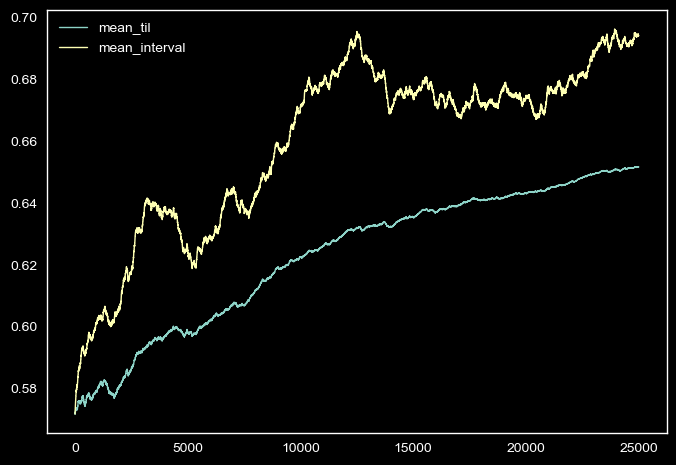

In [226]:
plt.style.use(['dark_background'])

interval = 5000
mean_til_lst = [sum(rList[:i])/len(rList[:i]) for i in range(interval, len(rList))]
mean_interval_lst = [np.array(rList[i-interval:i]).mean() for i in range(interval, len(rList))]

plt.plot(range(0, len(mean_til_lst)), mean_til_lst, linewidth=1, label='mean_til')
plt.plot(range(0, len(mean_interval_lst)), mean_interval_lst, linewidth=1, label='mean_interval')

plt.grid(False)
plt.legend()
plt.savefig("../../assets/images/markdown_img/180628_reinforce_q_network_plot.svg")
plt.show()

In [235]:
import gym
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt

def one_hot(x):
    return np.identity(16)[x:x+1]

env = gym.make('FrozenLake-v0')
"""
- obervation(현재 상황)을 입력받아서, 적절한 action을 내뱉는 네트워크를 구성합니다. 
- 사실, 이건 히든 레이어가 없는 네트워크라서 그냥 linear regression이라고 해도 상관없긴 합니다. 

- 그래요. 다 알겠는데 뭐가 X ,Y 인가요? 
X: observation 
Y: action 별 Quality 
"""
input_size = env.observation_space.n
output_size = env.action_space.n

learning_rate, decay_rate, num_episodes= 0.1, 0.99, 30000

X = tf.placeholder(shape=[None, input_size], dtype=tf.float32)
# X는 개별 상황, 즉 여기서는 16가지. 
W = tf.Variable(tf.random_uniform([input_size, output_size], 0, 0.01))

Qpred = tf.matmul(X, W) # 우리가 예측하는, Q 
Y = tf.placeholder(shape=[None, output_size], dtype=tf.float32)
# Y는 개별 상황(X)에서 취할 수 있는 action의 quality를 예측 

loss = tf.reduce_sum(tf.square(Y - Qpred))
train = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

rList = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(0, num_episodes):
        ### episode start
        state = env.reset()
        e = 1. / ((i/50)+10)
        rAll, done, local_loss = 0.0, False, []
        # q network training
        X_batch = []
        Q_batch = []
        while not done:
            Qs = sess.run(Qpred, feed_dict={X: one_hot(state)})
            action = env.action_space.sample() if np.random.rand(1) < e else np.argmax(Qs)
            new_state, reward, done, _ = env.step(action)
            if done: # terminal 
                Qs[0, action] = reward
            else: # non-terminal 
                Qs[0, action] = reward + decay_rate*np.max(sess.run(Qpred, feed_dict={X:one_hot(new_state)}))
            X_batch.append(one_hot(state))
            Q_batch.append(Qs)
            rAll += reward
            state = new_state
        # mini batch training
        sess.run(train, feed_dict={X: np.array(X_batch).reshape(len(X_batch), 16), 
                                   Y: np.array(Q_batch).reshape(len(Q_batch), 4)})
        ### episode end 
        rList.append(rAll)
print(sum(rList)/len(rList))

0.2074
